# 2. 線形回帰モデルを通して「解釈性」を理解する

In [1]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any  # 型ヒント用
from __future__ import annotations  # 型ヒント用

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib  # matplotlibの日本語表示対応

# 自作モジュール
sys.path.append("..")
from mli.visualize import get_visualization_setting

np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")  # warningsを非表示に

In [3]:
#ボストンの住宅価格データセット
from sklearn.datasets import load_boston

# データセットの読み込み
boston = load_boston()

# データセットはdictで与えられる
# dataに特徴量が、targetに目的変数が格納されている
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]

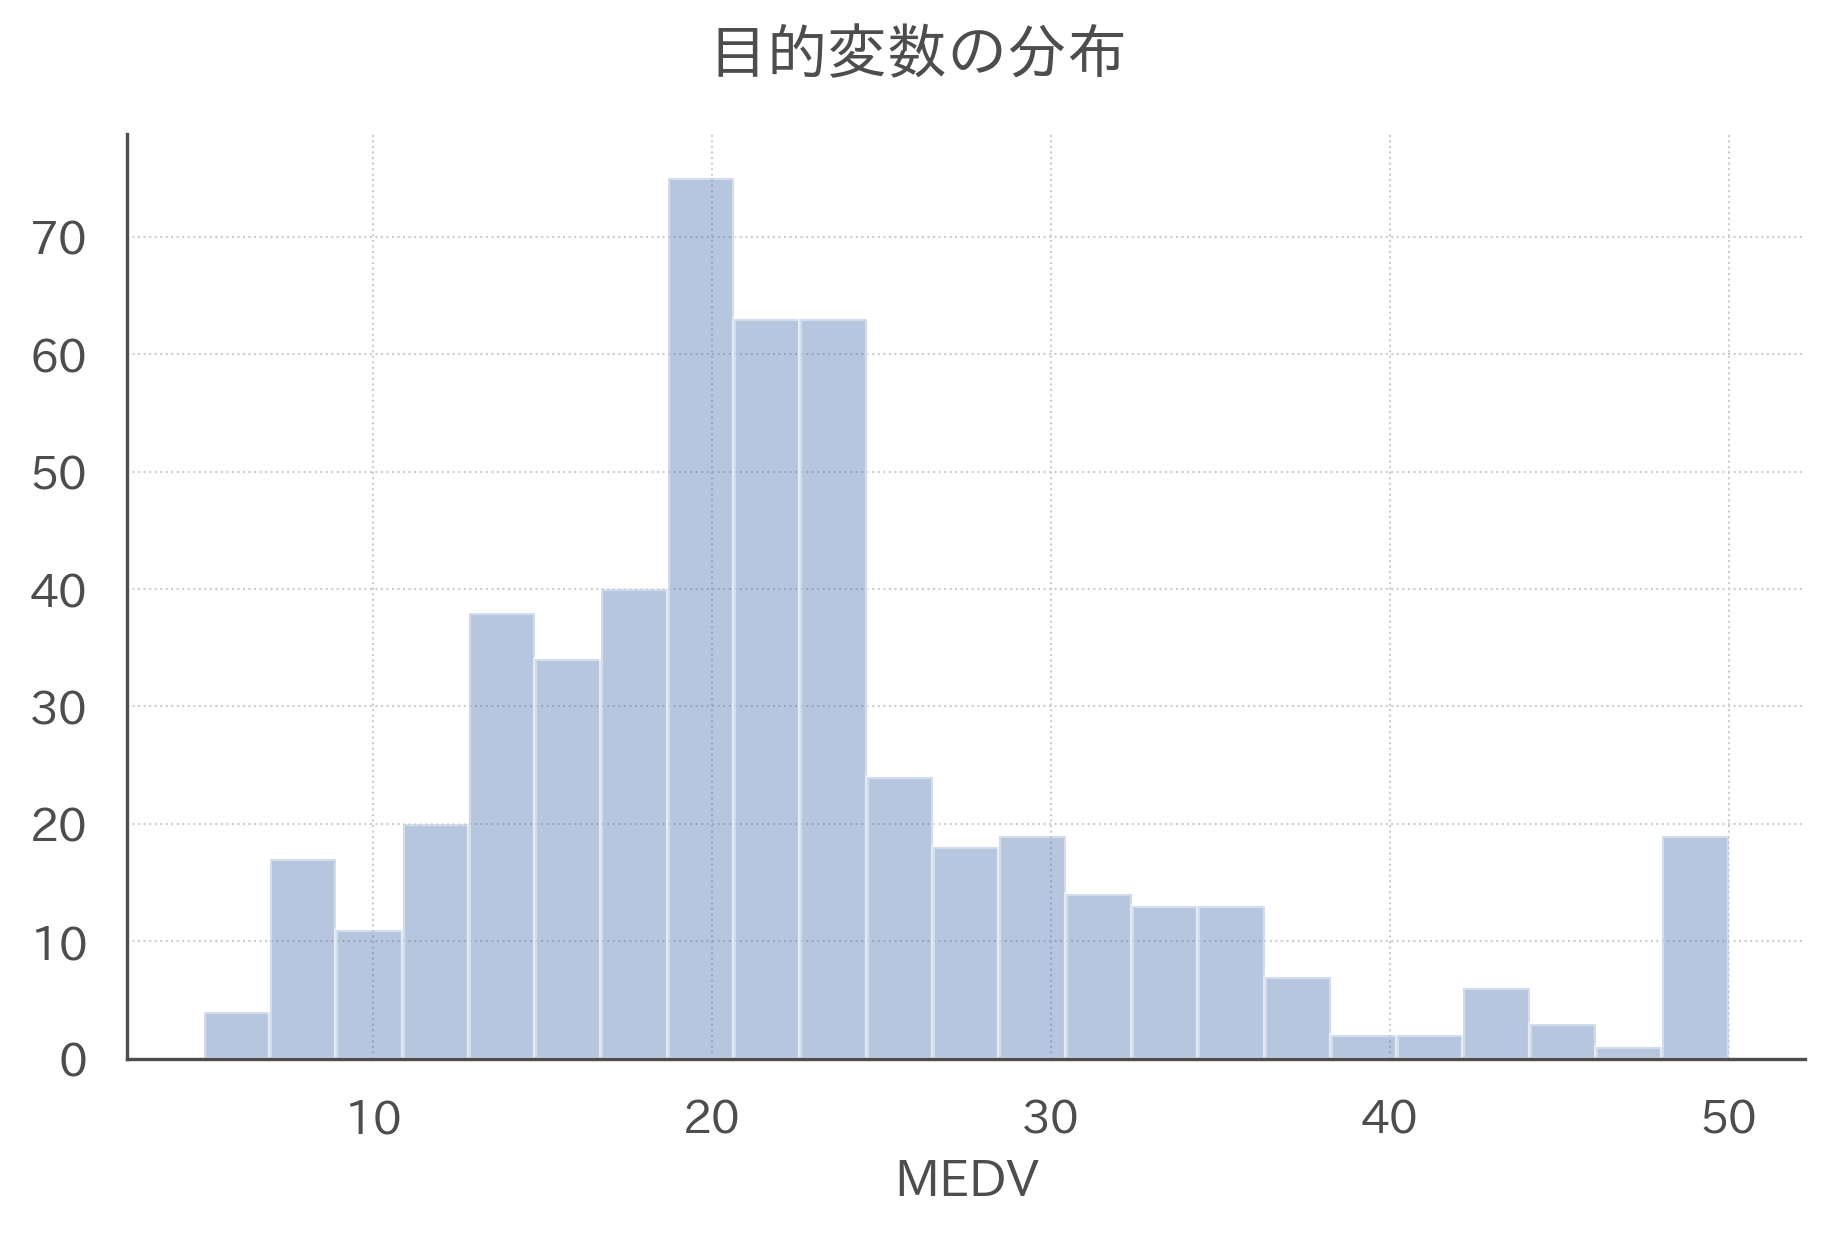

In [4]:
#予測したい目的変数は地域ごとの住宅価格の中央値
#目的変数の分布を確認

def plot_histogram(x, title=None, x_label=None):
    """与えられた特徴量のヒストグラムを作成"""
    
    fig, ax = plt.subplots()
    sns.distplot(x, kde=False, ax=ax)
    fig.suptitle(title)
    ax.set_xlabel(x_label)

    fig.show()


plot_histogram(y, title="目的変数の分布", x_label="MEDV")

In [5]:
# 特徴量を出力
X.head()


#注目する特徴量は下記の4つ
#平均的な部屋の数：RM
#地域の低所得層の割合：LSTAT
#都心からの距離：DIS
#犯罪率：CRIM

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33


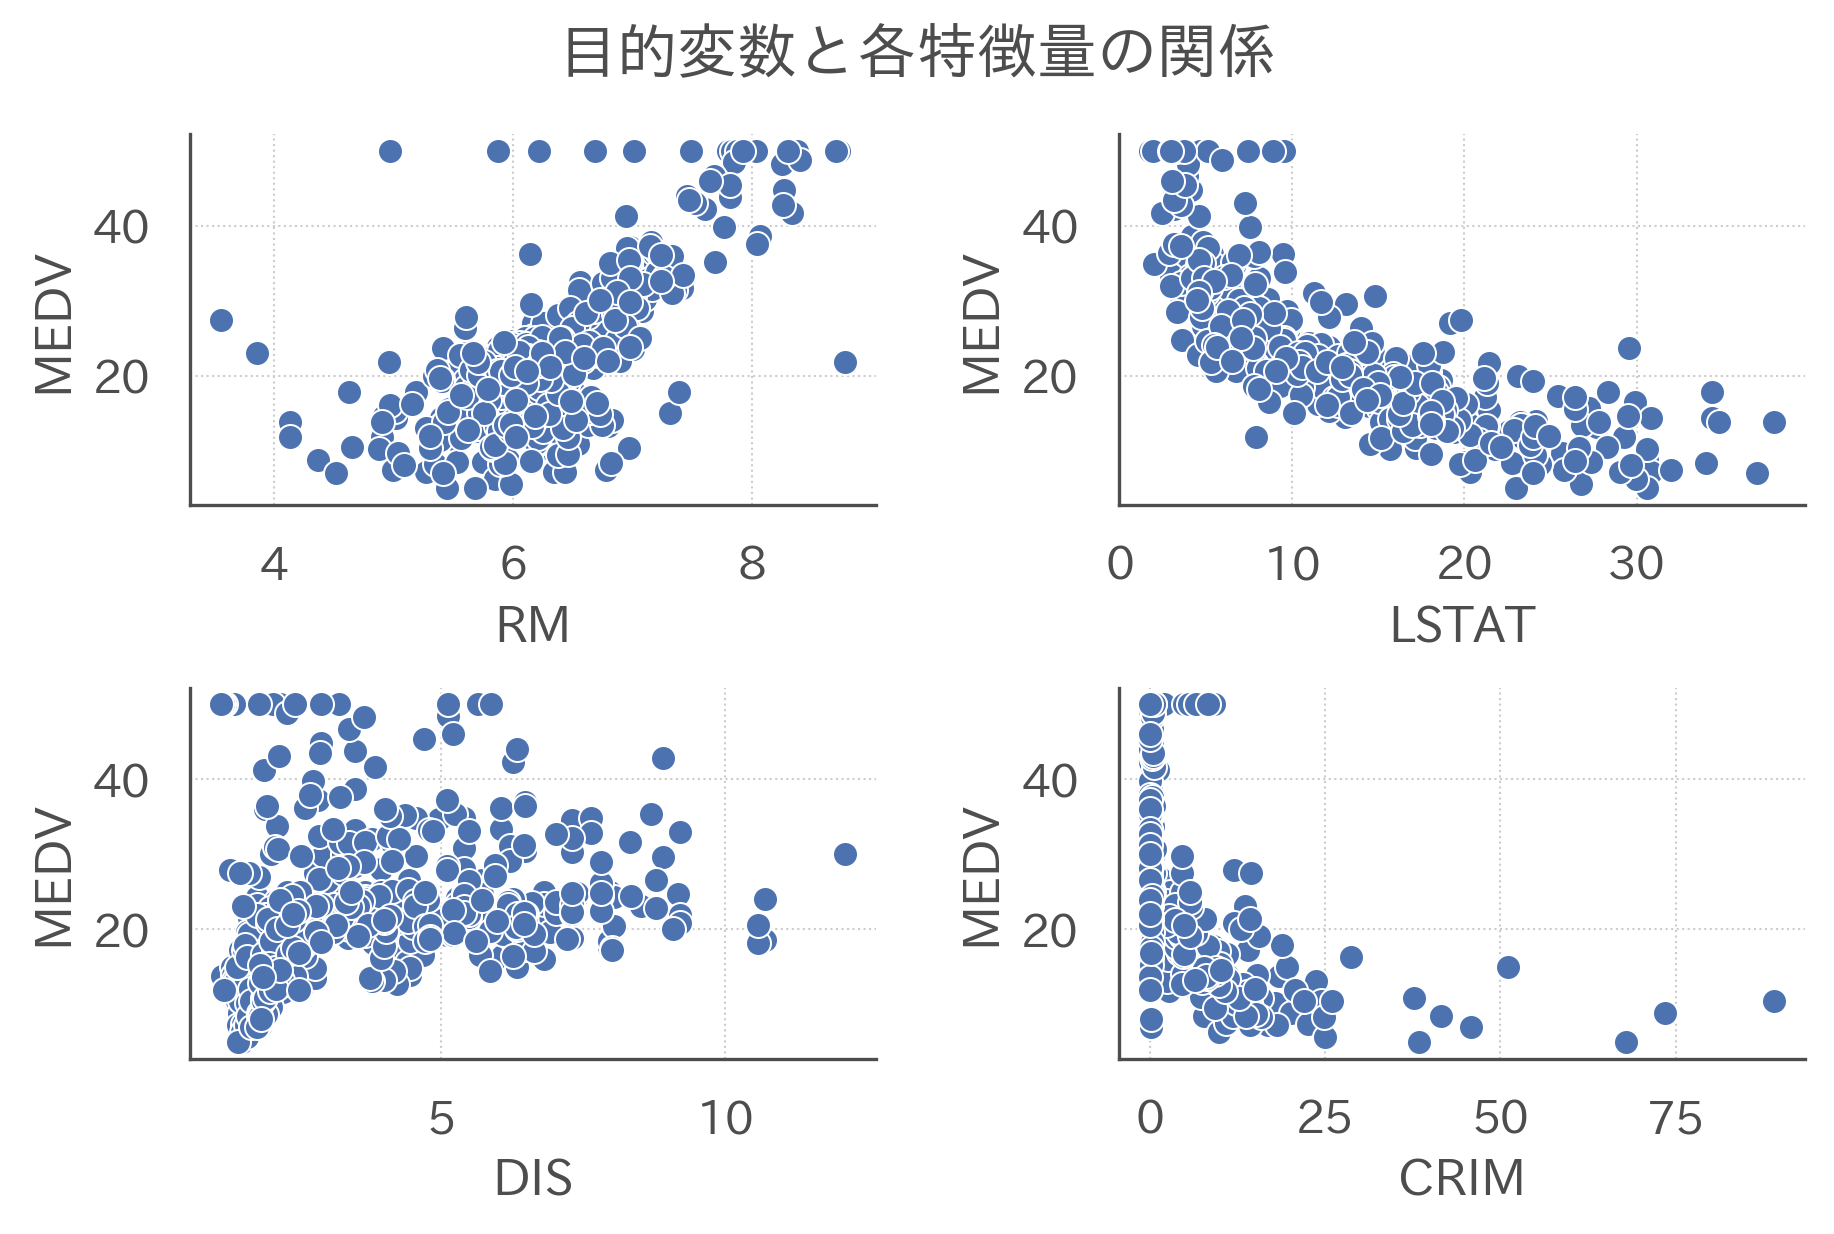

In [6]:
#目的変数である住宅価格の中央値MEDVとの関係を可視化
def plot_scatters(X, y, title=None):
    """目的変数と特徴量の散布図を作成"""
    
    cols = X.columns
    fig, axes = plt.subplots(nrows=2, ncols=2)

    for ax, c in zip(axes.ravel(), cols):
        sns.scatterplot(X[c], y, ci=None, ax=ax)
        ax.set(ylabel="MEDV")

    fig.suptitle(title)
    
    fig.show()


plot_scatters(
    X[["RM", "LSTAT", "DIS", "CRIM"]], 
    y, 
    title="目的変数と各特徴量の関係"
)

#平均的な部屋の数RMが増えるほど住宅価格が高くなる
#地域の低所得層の割合LSTATが増えるほど住宅価格が低くなる
#都心からの距離DISが大きくなるほど住宅価格が高くなる（イメージと逆）
#犯罪率CRIMが上がるほど住宅価格が低くなる

In [7]:
from sklearn.model_selection import train_test_split
import joblib  # pickleデータの書き出しと読み込み


# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 後で使えるようにデータを書き出しておく
joblib.dump(
    [X_train, X_test, y_train, y_test], 
    filename="../data/boston_housing.pkl"
)

['../data/boston_housing.pkl']

In [8]:
from sklearn.linear_model import LinearRegression


# 学習
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [10]:
#予測精度の確認
#RMSE,R^2の2つで確認

#RMSE：回帰モデルの代表的な制度評価の指標。平均的な予測誤差を表す指標
#R2：モデルがデータをどの程度説明できているか、
#ベースラインとしての平均値による予測と比べて、モデルによる予測によって予測誤差がどの程度改善しているか

from sklearn.metrics import mean_squared_error, r2_score


def regression_metrics(estimator, X, y):
    """回帰精度の評価指標をまとめて返す関数"""

    # テストデータで予測
    y_pred = estimator.predict(X)

    # 評価指標をデータフレームにまとめる
    df = pd.DataFrame(
        data={
            "RMSE": [mean_squared_error(y, y_pred, squared=False)],
            "R2": [r2_score(y, y_pred)],
        }
    )

    return df


# 精度評価
regression_metrics(lm, X_test, y_test)

#平均的に住宅価格を4.93だけ外している
#平均では予測できなかった住宅価格のうち約67%を予測できている

,RMSE,R2
0,4.93,0.67


In [11]:
#①特徴量と予測値の平均的な関係

#回帰係数を確認していく

#coef_として回帰係数が保存されている
#intercept_で切片情報にもアクセスできる

#ほかの章でも使うように関数をmli.utilityモジュールに保存しておく
def get_coef(estimator, var_names):
    """特徴量名と回帰係数が対応したデータフレームを作成する"""
    
    # 切片含む回帰係数と特徴量の名前を抜き出してデータフレームにまとめる
    df = pd.DataFrame(
        data={"coef": [estimator.intercept_] + estimator.coef_.tolist()}, 
        index=["intercept"] + var_names
    )
    
    return df


# 回帰係数の取り出し
df_coef = get_coef(lm, X.columns.tolist())
df_coef.T

#回帰係数は各特徴量が1単位だけ大きくなったときに住宅価格の予測値がどれだけ変化するかを表している
#平均的な部屋数RMが1大きくなると4.44
#低所得者の割合LSTATが1単位増えるごとに0.51小さくなる
#このように線形回帰モデルは特徴量と予測値の平均的な関係を解釈できる

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,30.25,-0.11,0.03,0.04,2.78,-17.20,4.44,-0.01,-1.45,0.26,-0.01,-0.92,0.01,-0.51


In [12]:
#②インスタンスごとの特徴量と予測値の関係

# 元のデータを上書きしないようにコピーしておく
X_train2 = X_train.copy()
X_test2 = X_test.copy()

#非線形モデルを表現するために、
# 2乗項を追加
X_train2["LSTAT2"] = X_train2["LSTAT"] ** 2
X_test2["LSTAT2"] = X_test2["LSTAT"] ** 2

# 学習
lm2 = LinearRegression()
lm2.fit(X_train2, y_train)

# 精度評価
regression_metrics(lm2, X_test2, y_test)

#R2が改善

,RMSE,R2
0,4.22,0.76


In [13]:
# 2乗項を追加した場合の回帰係数を出力
df_coef2 = get_coef(lm2, X_train2.columns.tolist())
df_coef2.T

#LSTATが1単位大きくなったときに予測値に与えるマイナスの影響はもともとのLSTATの水準が高くなればなるほど小さくなる

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,LSTAT2
coef,40.16,-0.13,0.01,0.05,2.48,-15.91,3.44,0.02,-1.26,0.26,-0.01,-0.79,0.01,-1.72,0.03


In [14]:
#インスタンスごとで確認するために、
# データを出力
X_test2.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,LSTAT2
173,0.09,0.00,4.05,0.00,0.51,6.42,84.10,2.65,5.00,296.00,16.60,395.50,9.04,81.72
274,0.06,40.00,6.41,1.00,0.45,6.76,32.90,4.08,4.00,254.00,17.60,396.90,3.53,12.46
491,0.11,0.00,27.74,0.00,0.61,5.98,98.80,1.87,4.00,711.00,20.10,390.11,18.07,326.52
72,0.09,0.00,10.81,0.00,0.41,6.07,7.80,5.29,4.00,305.00,19.20,390.91,5.52,30.47
452,5.09,0.00,18.10,0.00,0.71,6.30,91.80,2.37,24.00,666.00,20.20,385.09,17.27,298.25


In [15]:
#LSTATが1単位増加したときに予測値に与える影響を確認する

def calc_lstat_impact(df, lstat):
    """LSTATが１単位増加したときに予測値に与える影響"""

    return (df.loc["LSTAT"] + 2 * df.loc["LSTAT2"] * lstat).values[0]

# インスタンス274の場合
i = 274
lstat = X_test2.loc[i, "LSTAT"]
impact = calc_lstat_impact(df_coef2, lstat)

print(f"インスタンス{i}でLSTATが1単位増加したときの効果(LSTAT={lstat:.2f})：{impact:.2f}")

インスタンス274でLSTATが1単位増加したときの効果(LSTAT=3.53)：-1.48


In [17]:
# インスタンス491の場合
i = 491
lstat = X_test2.loc[i, "LSTAT"]
impact = calc_lstat_impact(df_coef2, lstat)

print(f"インスタンス{i}でLSTATが1単位増加したときの効果(LSTAT={lstat:.2f})：{impact:.2f}")

#低所得者の割合が高いインスタンスにおいては、低所得者の割合が増加したとしても、予測値に与える影響は小さい
#低所得者の割合が低いインスタンスにおいては、低所得者の割合が増加すると、予測値に与える影響が大きい

インスタンス491でLSTATが1単位増加したときの効果(LSTAT=18.07)：-0.50


In [19]:
#③特徴量の重要度を確認

# 回帰係数を出力
df_coef.T

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,30.25,-0.11,0.03,0.04,2.78,-17.20,4.44,-0.01,-1.45,0.26,-0.01,-0.92,0.01,-0.51


In [20]:
# 特徴量ごとの値の範囲を知るため、最大値と最小値の差分を確認
df_range = pd.DataFrame(data={"range": X_train.max() - X_train.min()})
df_range.T

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
range,88.97,100.00,27.00,1.00,0.49,4.92,97.10,11.00,23.00,524.00,9.40,396.58,36.24


In [21]:
#特徴量の標準化によって、係数を横並びで評価できるようにする

from sklearn.preprocessing import StandardScaler


# 訓練データから平均と分散を計算
ss = StandardScaler()
ss.fit(X_train)

# 標準化：平均を引いて標準偏差で割る
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# 学習
lm_ss = LinearRegression()
lm_ss.fit(X_train_ss, y_train)

# 精度評価
regression_metrics(lm_ss, X_test_ss, y_test)

,RMSE,R2
0,4.93,0.67


In [25]:
# 標準化された回帰係数を出力
df_coef_ss = get_coef(lm_ss, X_train.columns.tolist())
df_coef_ss.T

#低所得者の割合LSTATの回帰数が絶対値で最も大きい
#次に平均的な部屋の数RM
#これらの変数が住宅価格が予測するうえで重要な特徴量であることが示唆されている

#実務では費用対効果も検討しよう（テレビ広告とウェブ広告とか）

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,22.80,-1.00,0.70,0.28,0.72,-2.02,3.15,-0.18,-3.08,2.25,-1.77,-2.04,1.13,-3.61


In [26]:
#予測の理由をみていく

# 先頭のインスタンスを取り出す
Xi = X_test.iloc[[0]]

print(f"インスタンス{Xi.index[0]}に対する予測値：{lm.predict(Xi)[0]:.2f}")

インスタンス173に対する予測値：29.00


In [27]:
# 回帰係数を出力
df_coef.T

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,30.25,-0.11,0.03,0.04,2.78,-17.20,4.44,-0.01,-1.45,0.26,-0.01,-0.92,0.01,-0.51


In [28]:
# インスタンス173の特徴量を出力
Xi

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
173,0.09,0.00,4.05,0.00,0.51,6.42,84.10,2.65,5.00,296.00,16.60,395.50,9.04


In [30]:
# 各特徴量の値x回帰係数
Xi * df_coef.drop("intercept").values.T

#線形回帰モデルではインスタンスごとに「なぜこのような予測値を出したのか」という理由が解釈できる

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
173,-0.01,0.00,0.16,0.00,-8.77,28.48,-0.53,-3.83,1.31,-3.15,-15.20,4.88,-4.60


In [31]:
#より複雑な関係を学習できるブラックボックスモデルを利用することで、予測精度が向上する可能性がある
#一方で解釈性は落ちる

from sklearn.ensemble import RandomForestRegressor


# Random Forestの学習
# n_jobs=-1とすると利用可能なすべてのCPUを使って計算を並列化してくれる
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

rf.fit(X_train, y_train)

# モデルの書き出し
joblib.dump(rf, "../model/boston_housing_rf.pkl")

# テストデータで精度評価
regression_metrics(rf, X_test, y_test)

,RMSE,R2
0,2.81,0.89
